In [1]:
import pandas as pd
from pathlib import Path
import re

# ---- CONFIG: set your file path ----
# If your file is in Colab's /content after upload, this default should work.
FILE_PATH = Path("/content/Table-2-2024-25-Modality-Provider-Request-to-Test-2025-07-24-XLSX-181KB.csv")

# ---- Load (CSV by default; fallback to Excel if needed) ----
try:
    df = pd.read_csv(FILE_PATH)
except Exception:
    df = pd.read_excel(FILE_PATH)

# ---- Standardize column names ----
df = df.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# ---- Detect the provider column ----
provider_col_candidates = [c for c in df.columns if "provider" in c]
if not provider_col_candidates:
    raise ValueError("Could not find a provider column (looked for names containing 'provider').")
provider_col = provider_col_candidates[0]

# ---- Classifier: NHS if name contains 'nhs' or 'national health' (any case); else Private ----
nhs_pattern = re.compile(r"\bnhs\b|national\s+health(\s+service)?", re.IGNORECASE)

def classify_provider(name) -> str:
    if pd.isna(name):
        return "Unknown"
    return "NHS" if nhs_pattern.search(str(name)) else "Private"

df["provider_type"] = df[provider_col].apply(classify_provider)

# ---- (Optional) Quick sanity checks ----
print("Provider column detected:", provider_col)
print("\nCounts by provider_type:")
print(df["provider_type"].value_counts(dropna=False))

print("\nPreview:")
print(df[[provider_col, "provider_type"]].head(10))

# ---- (Optional) Save if you want a new CSV (uncomment to write) ----
# out_path = Path("/content/providers_with_type.csv")
# df.to_csv(out_path, index=False)
# print("Saved:", out_path)


Provider column detected: provider_name

Counts by provider_type:
provider_type
NHS        15552
Private     3608
Name: count, dtype: int64

Preview:
                                      provider_name provider_type
0  Aintree University Hospital NHS Foundation Trust           NHS
1  Aintree University Hospital NHS Foundation Trust           NHS
2  Aintree University Hospital NHS Foundation Trust           NHS
3  Aintree University Hospital NHS Foundation Trust           NHS
4  Aintree University Hospital NHS Foundation Trust           NHS
5  Aintree University Hospital NHS Foundation Trust           NHS
6  Aintree University Hospital NHS Foundation Trust           NHS
7  Aintree University Hospital NHS Foundation Trust           NHS
8  Aintree University Hospital NHS Foundation Trust           NHS
9  Aintree University Hospital NHS Foundation Trust           NHS


/tmp/ipython-input-3018957332.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  req[req_date_col] = pd.to_datetime(req[req_date_col], errors="coerce", dayfirst=True)
/tmp/ipython-input-3018957332.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rep[rep_date_col] = pd.to_datetime(rep[rep_date_col], errors="coerce", dayfirst=True)


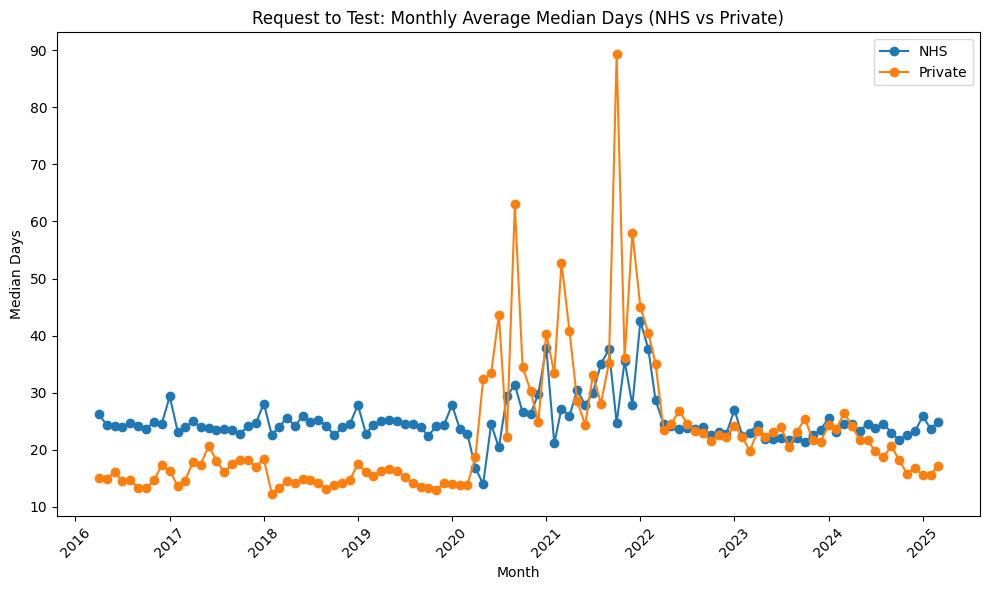

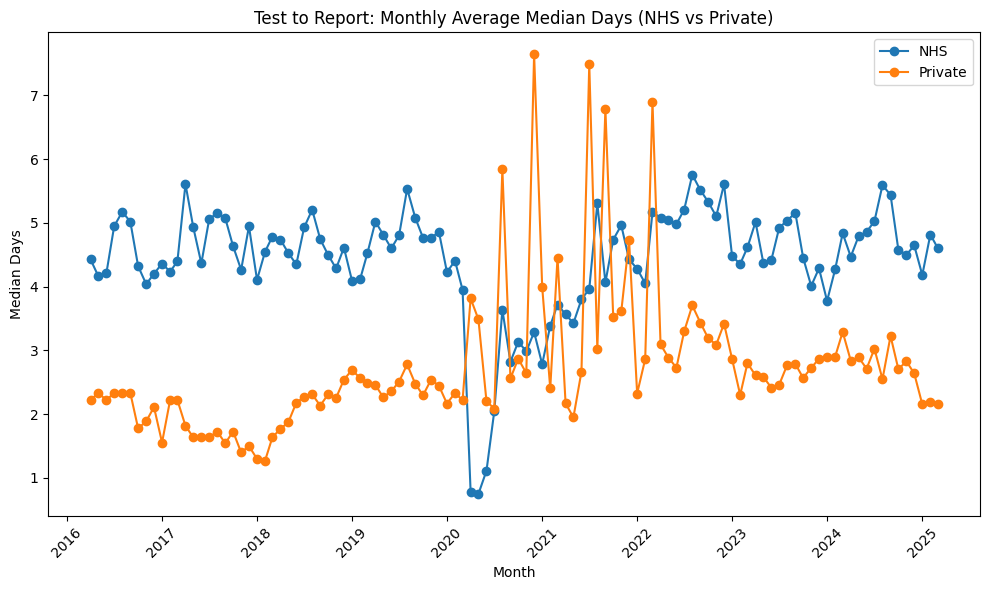

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Load datasets ---
req = pd.read_csv("/content/RequestToTest.csv")
rep = pd.read_csv("/content/Testreport_timeseries.csv")

# --- Standardize column names ---
req = req.rename(columns=lambda x: x.strip().replace(" ", "_").lower())
rep = rep.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# --- Detect provider columns ---
prov_col_req = next(c for c in req.columns if "provider" in c)
prov_col_rep = next(c for c in rep.columns if "provider" in c)

# --- Classify NHS vs Private ---
nhs_pattern = re.compile(r"\bnhs\b|national\s+health(\s+service)?", re.IGNORECASE)
def classify_provider(name) -> str:
    if pd.isna(name):
        return "Unknown"
    return "NHS" if nhs_pattern.search(str(name)) else "Private"

req["provider_type"] = req[prov_col_req].apply(classify_provider)
rep["provider_type"] = rep[prov_col_rep].apply(classify_provider)

# --- Detect date columns and parse ---
req_date_col = next(c for c in req.columns if "date" in c)
rep_date_col = next(c for c in rep.columns if "date" in c)
req[req_date_col] = pd.to_datetime(req[req_date_col], errors="coerce", dayfirst=True)
rep[rep_date_col] = pd.to_datetime(rep[rep_date_col], errors="coerce", dayfirst=True)

# --- Detect value columns ---
req_val_col = next(c for c in req.columns if "median" in c and "request" in c)
rep_val_col = next(c for c in rep.columns if "median" in c and "report" in c)

req[req_val_col] = pd.to_numeric(req[req_val_col], errors="coerce")
rep[rep_val_col] = pd.to_numeric(rep[rep_val_col], errors="coerce")

# --- Compute monthly averages by provider type ---
req["year_month"] = req[req_date_col].dt.to_period("M").dt.to_timestamp()
rep["year_month"] = rep[rep_date_col].dt.to_period("M").dt.to_timestamp()

req_monthly = (
    req.groupby(["year_month", "provider_type"])[req_val_col]
    .mean()
    .reset_index()
)
rep_monthly = (
    rep.groupby(["year_month", "provider_type"])[rep_val_col]
    .mean()
    .reset_index()
)

# --- Plot Request to Test ---
plt.figure(figsize=(10,6))
for ptype in ["NHS", "Private"]:
    subset = req_monthly[req_monthly["provider_type"] == ptype]
    plt.plot(subset["year_month"], subset[req_val_col], marker="o", label=ptype)
plt.title("Request to Test: Monthly Average Median Days (NHS vs Private)")
plt.xlabel("Month")
plt.ylabel("Median Days")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Test to Report ---
plt.figure(figsize=(10,6))
for ptype in ["NHS", "Private"]:
    subset = rep_monthly[rep_monthly["provider_type"] == ptype]
    plt.plot(subset["year_month"], subset[rep_val_col], marker="o", label=ptype)
plt.title("Test to Report: Monthly Average Median Days (NHS vs Private)")
plt.xlabel("Month")
plt.ylabel("Median Days")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-1300097667.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  req[req_date_col] = pd.to_datetime(req[req_date_col], errors="coerce", dayfirst=True)
/tmp/ipython-input-1300097667.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rep[rep_date_col] = pd.to_datetime(rep[rep_date_col], errors="coerce", dayfirst=True)


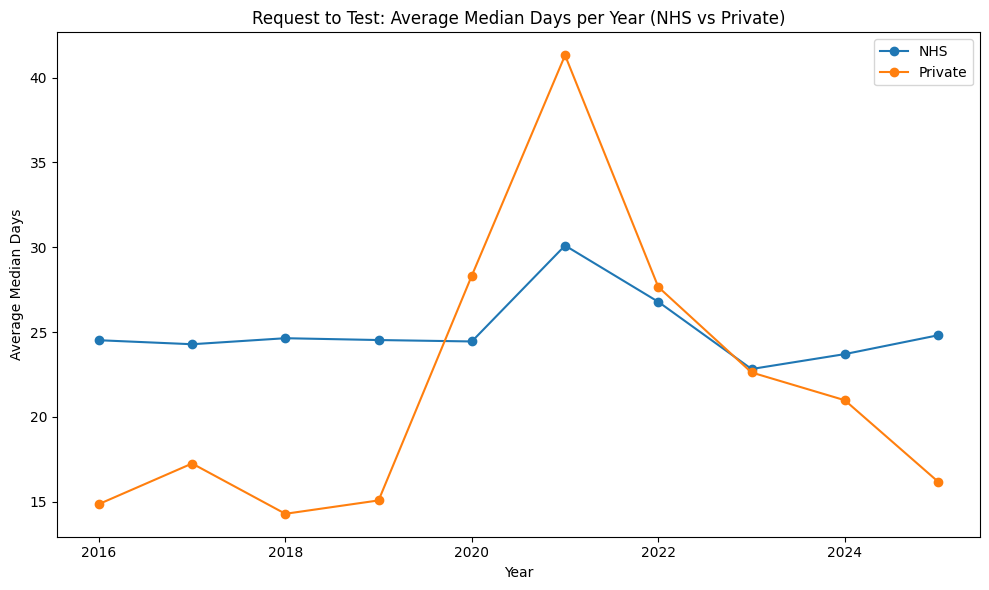

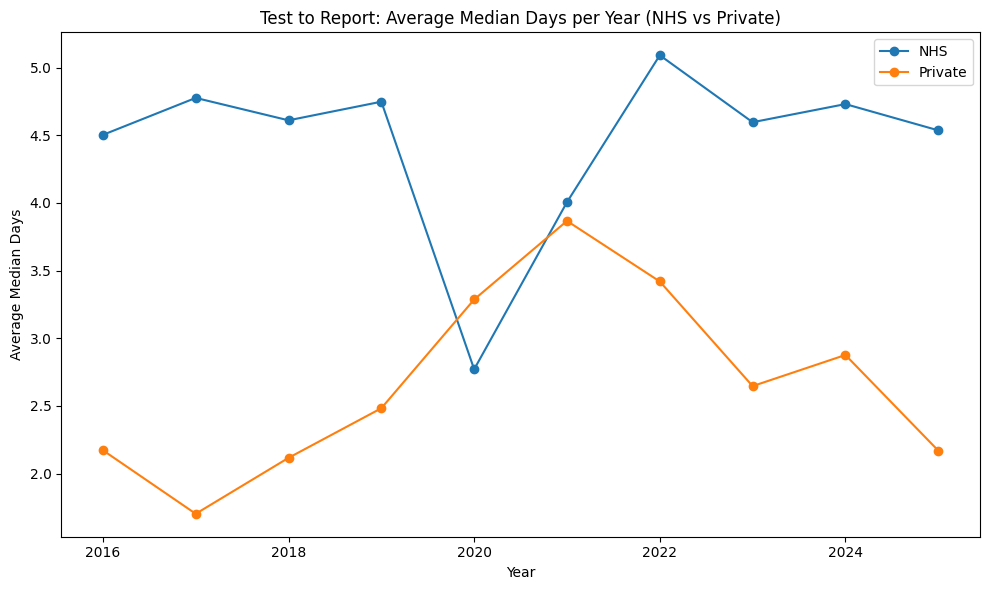

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Load datasets ---
req = pd.read_csv("/content/RequestToTest.csv")
rep = pd.read_csv("/content/Testreport_timeseries.csv")

# --- Standardize column names ---
req = req.rename(columns=lambda x: x.strip().replace(" ", "_").lower())
rep = rep.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# --- Detect provider columns ---
prov_col_req = next(c for c in req.columns if "provider" in c)
prov_col_rep = next(c for c in rep.columns if "provider" in c)

# --- Classify NHS vs Private ---
nhs_pattern = re.compile(r"\bnhs\b|national\s+health(\s+service)?", re.IGNORECASE)
def classify_provider(name) -> str:
    if pd.isna(name):
        return "Unknown"
    return "NHS" if nhs_pattern.search(str(name)) else "Private"

req["provider_type"] = req[prov_col_req].apply(classify_provider)
rep["provider_type"] = rep[prov_col_rep].apply(classify_provider)

# --- Detect date columns and parse ---
req_date_col = next(c for c in req.columns if "date" in c)
rep_date_col = next(c for c in rep.columns if "date" in c)
req[req_date_col] = pd.to_datetime(req[req_date_col], errors="coerce", dayfirst=True)
rep[rep_date_col] = pd.to_datetime(rep[rep_date_col], errors="coerce", dayfirst=True)

# --- Detect value columns ---
req_val_col = next(c for c in req.columns if "median" in c and "request" in c)
rep_val_col = next(c for c in rep.columns if "median" in c and "report" in c)

req[req_val_col] = pd.to_numeric(req[req_val_col], errors="coerce")
rep[rep_val_col] = pd.to_numeric(rep[rep_val_col], errors="coerce")

# --- Extract year ---
req["year"] = req[req_date_col].dt.year
rep["year"] = rep[rep_date_col].dt.year

# --- Group by year & provider type ---
req_yearly = req.groupby(["year", "provider_type"])[req_val_col].mean().reset_index()
rep_yearly = rep.groupby(["year", "provider_type"])[rep_val_col].mean().reset_index()

# --- Plot Request to Test (per year) ---
plt.figure(figsize=(10,6))
for ptype in ["NHS", "Private"]:
    subset = req_yearly[req_yearly["provider_type"] == ptype]
    plt.plot(subset["year"], subset[req_val_col], marker="o", label=ptype)
plt.title("Request to Test: Average Median Days per Year (NHS vs Private)")
plt.xlabel("Year")
plt.ylabel("Average Median Days")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Test to Report (per year) ---
plt.figure(figsize=(10,6))
for ptype in ["NHS", "Private"]:
    subset = rep_yearly[rep_yearly["provider_type"] == ptype]
    plt.plot(subset["year"], subset[rep_val_col], marker="o", label=ptype)
plt.title("Test to Report: Average Median Days per Year (NHS vs Private)")
plt.xlabel("Year")
plt.ylabel("Average Median Days")
plt.legend()
plt.tight_layout()
plt.show()
